# Cloud Cost Anomaly Detection & Forecasting Using Data Analytics

* With enterprises rapidly scaling their operations on cloud platforms (AWS, Azure, GCP), cloud bills have become a major controllable cost factor. Many IT companies face:  
    * Unexpected spikes in usage leading to surprise bills.
    * Underutilized or idle resources consuming budget.
    * Anomalies caused by misconfigurations, attacks, or runaway jobs.
* Business leaders (CFOs, CTOs, Engineering Managers) need data-driven visibility into usage and spend patterns to forecast budgets accurately, detect anomalies early, and enforce governance.
* This project’s objective is to demonstrate how data analytics can reduce waste, improve efficiency, and prevent unexpected cloud overspend.

**Business Problem**
* Cloud cost overruns and anomalies lead to:
    * 20–40% overspending annually due to lack of governance and transparency.
    * Difficulty identifying which team/service/region caused the spike.
    * Inability to predict future spend accurately, leading to budget shocks.
    * SLA breaches when anomalies impact customer-facing workloads.
* Without robust anomaly detection and forecasting, IT companies lose millions and undermine operational efficiency.

**Goal**
* To build an end-to-end analytics solution that:
    * Detects and flags anomalous cloud spending in near real-time.
    * Forecasts future spend using statistical and machine learning models.
    * Identifies cost-saving opportunities by analyzing underutilized resources.
    * Provides actionable dashboards for both executives (strategic view) and engineers (operational root-cause analysis).

## Exploratory Data Analysis

### Importing Libraries + Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns

In [2]:
df = pd.read_parquet('clean_cloud_data.parquet')

In [3]:
df.head(10)

,timestamp,resource_id,service_tag,service_canonical,region,team,instance_type,usage,usage_unit,cost_usd,currency,owner,source_ip,cost_imputed_flag,is_outlier
0,2024-10-10 06:32:31.665035,9f546ae5,S3,S3,us-west-2,search,t3.medium,1.294475,GB-hours,3.660000e-06,USD,udavis,210.90.217.45,False,False
1,2025-06-08 02:19:47.665035,78e0807a,EC2,EC2,us-west-2,search,m5.large,5.549555,vCPU-hours,2.774778e-01,USD,mrosario,22.219.141.112,True,True
2,2025-07-26 04:59:10.665035,cf9713a0,EC2,EC2,eu-west-1,infra,m5.large,11.416323,vCPU-hours,5.059163e-01,USD,cjackson,208.132.8.249,False,True
3,2025-08-31 21:54:40.665035,71c42bb1,EC2,EC2,eu-west-1,Unknown,spot-small,0.479407,vCPU-hours,3.400440e-04,USD,harringtontimothy,49.94.27.144,False,False
4,2025-03-10 12:51:34.665035,5ddba1b8,EBS,EBS,ap-south-1,Unknown,r5.large,21.487007,GB-hours,1.270440e-04,USD,jason04,122.212.132.65,False,False
5,2025-09-19 16:15:57.665035,e1eb527d,ELB,ELB,eu-west-1,payments,spot-small,124.000000,requests,1.380984e-03,USD,walterherrera,27.143.221.40,False,False
6,2025-04-05 08:24:31.665035,a2ec574d,Lambda,Lambda,ap-south-1,payments,c5.xlarge,383.042823,requests,7.560000e-07,USD,connorhardy,182.213.230.111,False,False
7,2025-01-17 03:38:18.665035,16aa964c,Lambda,Lambda,eu-west-1,search,r5.large,191.000000,requests,4.000000e-05,USD,charles65,205.9.71.87,False,False
8,2025-08-03 22:09:36.665035,b609411d,RDS,RDS,us-east-1,devtools,c5.xlarge,0.535388,vCPU-hours,4.940520e-04,USD,james16,45.27.149.136,False,False
9,2025-04-15 18:15:01.665035,d0a92372,CloudFront,CloudFront,us-east-1,payments,t3.medium,21.101344,GB-hours,2.956800e-05,USD,thompsondeanna,57.239.87.105,False,False


In [4]:
df.shape[0]

990024

In [5]:
df.shape[1]

15

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990024 entries, 0 to 990023
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          990024 non-null  datetime64[ns]
 1   resource_id        990024 non-null  string        
 2   service_tag        990024 non-null  string        
 3   service_canonical  990024 non-null  object        
 4   region             990024 non-null  string        
 5   team               990024 non-null  string        
 6   instance_type      990024 non-null  string        
 7   usage              990024 non-null  float64       
 8   usage_unit         990024 non-null  object        
 9   cost_usd           990024 non-null  float64       
 10  currency           990024 non-null  object        
 11  owner              990024 non-null  string        
 12  source_ip          990024 non-null  string        
 13  cost_imputed_flag  990024 non-null  bool    

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp,990024,NaN,NaN,NaN,2025-03-25 19:31:43.348280832,2024-09-24 09:07:48.665035,2024-12-24 12:55:01.915035136,2025-03-25 19:00:40.665035008,2025-06-25 02:07:13.915035136,2025-09-24 09:06:20.665035,NaN
resource_id,990024,989878,0ac06246,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service_tag,990024,8,ELB,124646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service_canonical,990024,8,ELB,124646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,990024,4,us-west-2,247965,NaN,NaN,NaN,NaN,NaN,NaN,NaN
team,990024,8,Unknown,220404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instance_type,990024,7,r5.large,141783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usage,990024.0,NaN,NaN,NaN,79.092907,0.007001,3.804575,13.452728,55.483196,697303.713424,1529.195139
usage_unit,990024,3,GB-hours,370698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cost_usd,990024.0,NaN,NaN,NaN,0.106787,0.0,0.0002,0.004176,0.063216,675.786806,1.901622


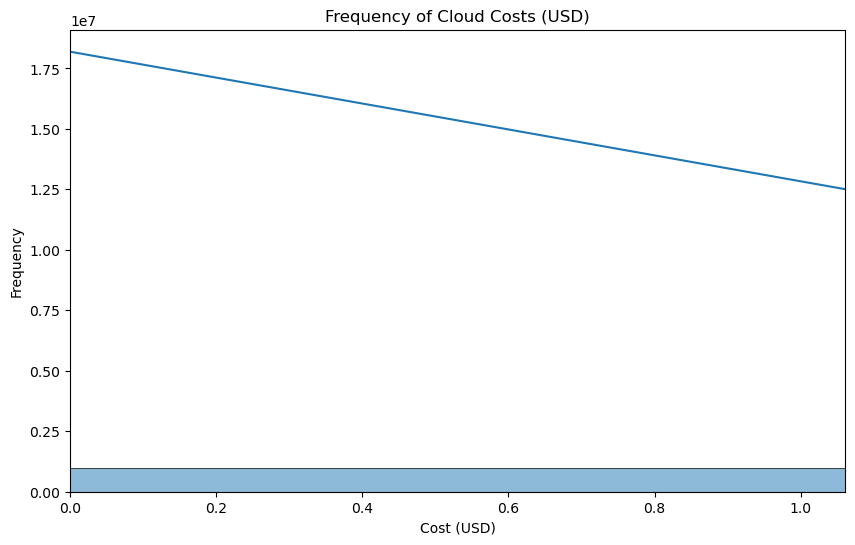

In [8]:
# Distribution of cost and usage

plot.figure(figsize=(10,6))
sns.histplot(df['cost_usd'], bins=100, kde=True)
plot.xlim(0, df['cost_usd'].quantile(0.99))
plot.title('Frequency of Cloud Costs (USD)')
plot.xlabel('Cost (USD)')
plot.ylabel('Frequency')
plot.show()

#### Insights:
* As we can see from the dataset, most of the cloud usage costs are extremely small.
* The plot shows a steep decline where most costs are clustered near 0 USD and very few costs are closer to 1 USD.
* Larger costs are rare, as the frequency suddenly decreased when the cost increases.
* This shows that the data is heavily skewed to lower costs.
* The costs of majority of the services in this dataset is very close to 0. Very few services have higher costs.

Text(0.5, 1.0, 'Service-wise Cost Distribution')

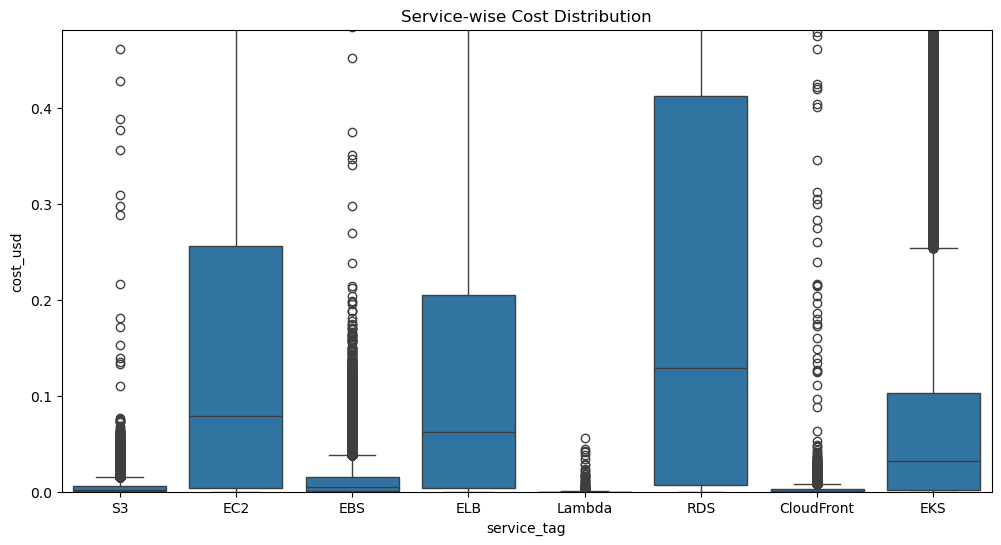

In [9]:
# Boxplot by service

plot.figure(figsize=(12,6))
sns.boxplot(data=df, x='service_tag', y='cost_usd')
plot.ylim(0, df['cost_usd'].quantile(0.95))
plot.title('Service-wise Cost Distribution')

#### Insights:
* RDS (Relational Database Service)
    * It has high median cost among all services.
    * The spread is huge showing showing some RDS usage is expensive compared to others.
* EC2 (Compute instances) and EKS (Kubernetes service)
    * EC2 services have fairly high median costs while it is low for EKS.
    * EC2 has a wide range of costs, meaning usage patterns vary a lot.
    * EKS also has several high cost outliers.
* ELB (Elastic Laod Balancer)
    * The costs of ELB services are in mid-range and the spread is moderate.
* S3 (Storage), CloudFront (CDN), Lambda (Serverless), EBS (Block Storage)
    * These services have very low median costs.
    * They also show many outliers which are occassional large costs for some users.
* In this dataset, EKS, EC2 and RDS appears to be the most expensive services.
* S3, CloudFront, Lambda and EBS are usually but can spike for certain use cases.
* This shows that cost distribution is highly skewed where most usage is low-cost but few cases get very expensive.

#### Time Series Exploration

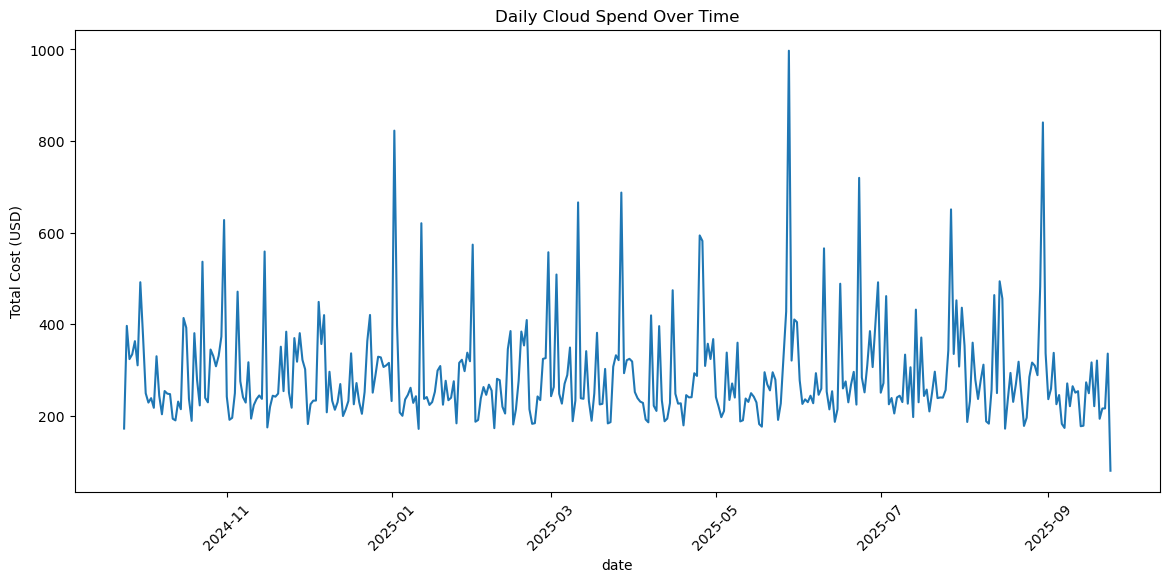

In [10]:
# Time series analysis
# Daily spend trends

df['date'] = df['timestamp'].dt.date
daily_cost = df.groupby('date')['cost_usd'].sum().reset_index()

plot.figure(figsize=(14,6))
sns.lineplot(data=daily_cost, x='date', y='cost_usd')
plot.title('Daily Cloud Spend Over Time')
plot.ylabel('Total Cost (USD)')
plot.xticks(rotation=45)
plot.show()

In [27]:
df.head(10)

,timestamp,resource_id,service_tag,service_canonical,region,team,instance_type,usage,usage_unit,cost_usd,currency,owner,source_ip,cost_imputed_flag,is_outlier,date
0,2024-10-10 06:32:31.665035,9f546ae5,S3,S3,us-west-2,search,t3.medium,1.294475,GB-hours,3.660000e-06,USD,udavis,210.90.217.45,False,False,2024-10-10
1,2025-06-08 02:19:47.665035,78e0807a,EC2,EC2,us-west-2,search,m5.large,5.549555,vCPU-hours,2.774778e-01,USD,mrosario,22.219.141.112,True,True,2025-06-08
2,2025-07-26 04:59:10.665035,cf9713a0,EC2,EC2,eu-west-1,infra,m5.large,11.416323,vCPU-hours,5.059163e-01,USD,cjackson,208.132.8.249,False,True,2025-07-26
3,2025-08-31 21:54:40.665035,71c42bb1,EC2,EC2,eu-west-1,Unknown,spot-small,0.479407,vCPU-hours,3.400440e-04,USD,harringtontimothy,49.94.27.144,False,False,2025-08-31
4,2025-03-10 12:51:34.665035,5ddba1b8,EBS,EBS,ap-south-1,Unknown,r5.large,21.487007,GB-hours,1.270440e-04,USD,jason04,122.212.132.65,False,False,2025-03-10
5,2025-09-19 16:15:57.665035,e1eb527d,ELB,ELB,eu-west-1,payments,spot-small,124.000000,requests,1.380984e-03,USD,walterherrera,27.143.221.40,False,False,2025-09-19
6,2025-04-05 08:24:31.665035,a2ec574d,Lambda,Lambda,ap-south-1,payments,c5.xlarge,383.042823,requests,7.560000e-07,USD,connorhardy,182.213.230.111,False,False,2025-04-05
7,2025-01-17 03:38:18.665035,16aa964c,Lambda,Lambda,eu-west-1,search,r5.large,191.000000,requests,4.000000e-05,USD,charles65,205.9.71.87,False,False,2025-01-17
8,2025-08-03 22:09:36.665035,b609411d,RDS,RDS,us-east-1,devtools,c5.xlarge,0.535388,vCPU-hours,4.940520e-04,USD,james16,45.27.149.136,False,False,2025-08-03
9,2025-04-15 18:15:01.665035,d0a92372,CloudFront,CloudFront,us-east-1,payments,t3.medium,21.101344,GB-hours,2.956800e-05,USD,thompsondeanna,57.239.87.105,False,False,2025-04-15


### Insights:
* The total daily cloud cost shows noticeable ups and downs throughout the year.
* Significant spikes appear in January 2025 where daily costs cross 800 USD, another sharp rise occurs at the end of May 2025 reaching around 1,000 USD, and a sudden increase is seen again in September 2025 with costs close to USD 800.
* These spikes may be linked to increased user activity such as heavier service usage, large-scale data uploads, or other events that triggered higher resource consumption.

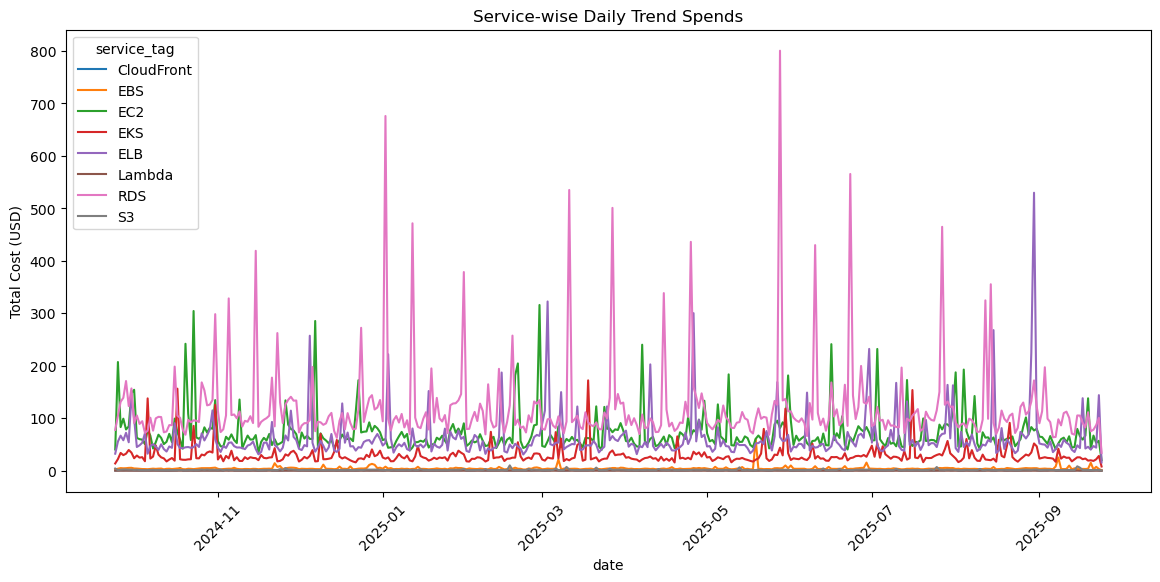

In [11]:
# Service contribution over time

daily_service = df.groupby(['date', 'service_tag'])['cost_usd'].sum().reset_index()

plot.figure(figsize=(14,6))
sns.lineplot(data=daily_service, x='date', y='cost_usd', hue='service_tag')
plot.title('Service-wise Daily Trend Spends')
plot.xlabel('date')
plot.ylabel('Total Cost (USD)')
plot.xticks(rotation=45)
plot.show()

#### Insights:

* RDS services show the highest daily costs, with major spikes in January 2025 of ~700 USD and May 2025 of ~800. This confirms that RDS was the main driver behind the large cost peaks we saw earlier in the overall trend.
* Database workloads are consistently the most expensive. This suggests the company should carefully monitor RDS usage, optimize instance sizing, or evaluate alternatives (e.g., reserved/spot instances).
* The sharp cost spike in September 2025 was caused mainly by ELB services. It appears like a anomaly. This surge may indicate a traffic surge, misconfiguration, or even attack like activity. Such anomalies need root cause analysis.
* EKS services generally cost less than 50 USD per day, but occasional jumps cross 100–150 USD, showing some fluctuations in container usage. This sudden jump could indicate auto-scaling of Kubernetes clusters, worth validating if scaling is tuned correctly.
* EC2 and ELB are stable but cost heavy. These are compute + load balancing services. Their cost pattern shows baseline infrastructure spend, but still requires optimization.
* All other services (S3, Lambda, CloudFront, etc.) contribute very little to daily costs in this dataset, mostly close to zero. This means storage and serverless costs are minimal here and primary focus should remain on databases (RDS) and traffic management (ELB/EC2).

#### Outlier/Anomaly Patterns

In [12]:
# Outlier share by service

outlier_share = df.groupby('service_tag')['is_outlier'].mean().sort_values(ascending=False)
outlier_share

service_tag
RDS           0.464953
EC2           0.364944
ELB           0.314114
EKS           0.149227
EBS           0.000752
CloudFront    0.000420
S3            0.000365
Lambda        0.000000
Name: is_outlier, dtype: float64

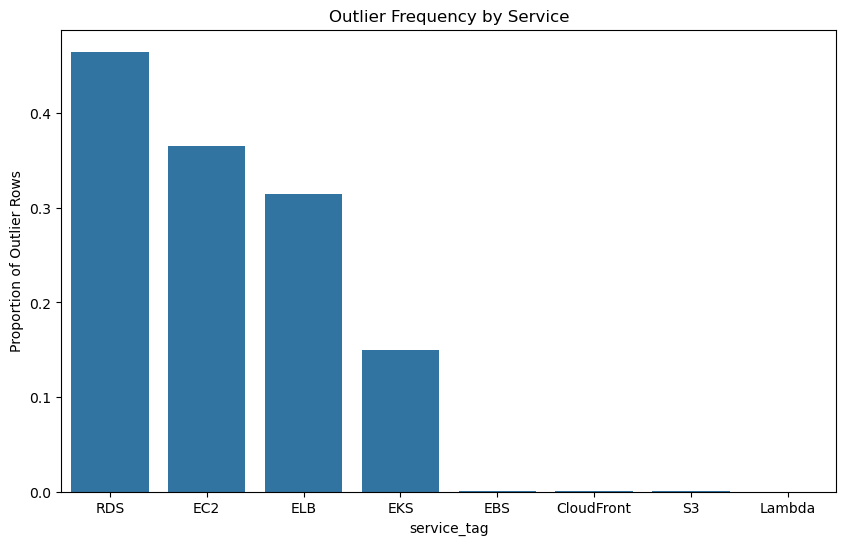

In [13]:
plot.figure(figsize=(10,6))
sns.barplot(x=outlier_share.index, y=outlier_share.values)
plot.title('Outlier Frequency by Service')
plot.ylabel('Proportion of Outlier Rows')
plot.show()

#### Insights:
* RDS is alone contributing to more than 40% of all anomalies. This indicate that unstable cost drivers.
* With over 40% of anomalies tied to RDS, it means that database workloads are unpredictable and often exceed normal cost levels.
* This could be due to inefficient queries, poor instance sizing, sudden spikes in application demand or unoptimized storage.
* For management, RDS needs priority monitoring and optimization, since it's both expensive and highly variable.
* Other core infrastructures like EC2, ELB and EKS are the next biggest risks. These services form the backbone of most IT systems. Their anomaly presence suggests frequent scaling events, misconfigurations or sudden demand spikes.
* For stakeholders, cost governance and auto-scaling policies should be reviewed for these services.
* Other services like EBS, CloudFront, S3 and Lambda are stable as we can observe few anomalies here. These services run at predictable, low cost.
* They don't need heavy monitoring right now, attention should be kept on the big 4 (RDS, EC2, ELB, EKS).
* Most of the unpredictable cost spikes are coming from databases and compute services, not from storage or serverless. This means the company should focus its cost optimization efforts on RDS and core compute, rather than spreading resources evenly across all services.

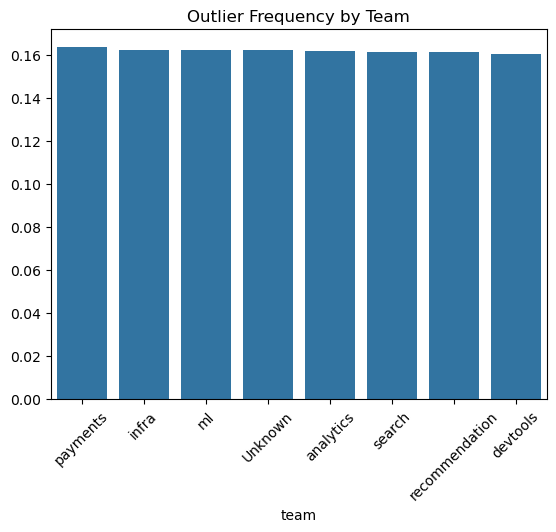

In [14]:
# Outlier share by team

outlier_team = df.groupby('team')['is_outlier'].mean().sort_values(ascending=False)
sns.barplot(x=outlier_team.index, y=outlier_team.values)
plot.title('Outlier Frequency by Team')
plot.xticks(rotation=45)
plot.show()

#### Insights:
* Across teams, anomaly contribution is fairly balanced at around 16% each, with the Payments team slightly higher and the Development Tools team slightly lower than others.
* This means that anomalies are not isolated to one team.
* Since anomalies are spread fairly evenly across teams, cost irregularities are company wide issue and not just responsibility of one group.
* For leadership, this means cloud cost governance must be organization wide, with shared accountability.
* Payments team showing slightly higher anomalies indicate that payment systems are more resource intensive and prone to spikes.
* For stakeholders, payments may need closer monitoring to ensure stability and cost predictability, since it's often a business critical system.
* Lower anomalies shown by Development Tools team suggests that DevTools workloads are more stable and predictable.
* For finance/operations team, optimization should remain on higher impact teams rather than spending time on already stable groups.
* Anomalies are happening across almost all teams, so this is an organization-wide cost management issue. But, the Payments team stands out slightly higher, meaning they may need special attention and deeper cost reviews, while Development Tools are low-risk.

#### Imputation Analysis

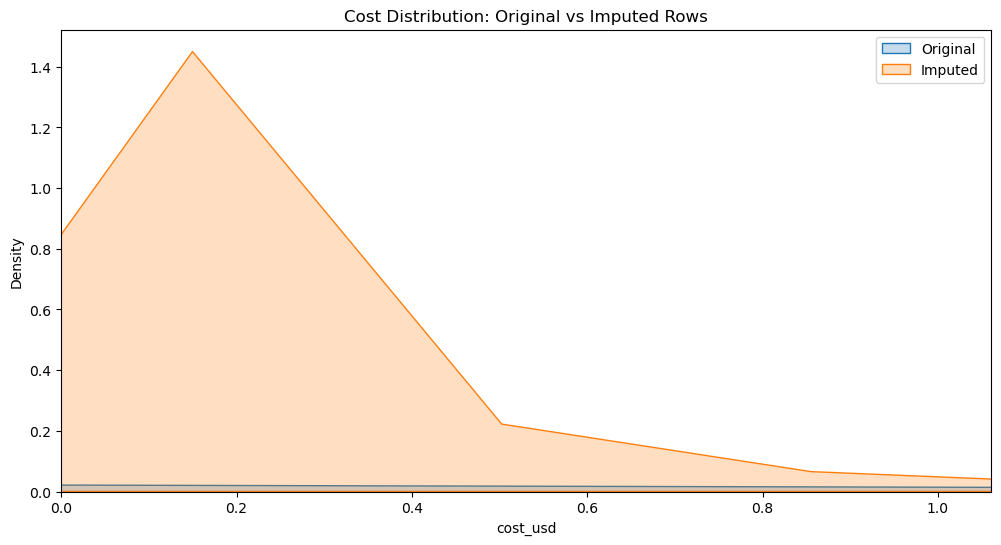

In [15]:
plot.figure(figsize=(12,6))
sns.kdeplot(df.loc[df['cost_imputed_flag']==0, 'cost_usd'], label='Original', fill=True)
sns.kdeplot(df.loc[df['cost_imputed_flag']==1, 'cost_usd'], label='Imputed', fill=True)
plot.xlim(0, df['cost_usd'].quantile(0.99))
plot.title('Cost Distribution: Original vs Imputed Rows')
plot.legend()
plot.show()

#### Insights:
* The imputed cost values are most dense between 0 to 0.5 USD and their frequency decreases as the cost increases.
* This shows that the dataset has large number of low cost entries and the overall cost distribution is heavily skewed toward lower values.
* However, the imputed rows do not follow the same distribution as original rows, which suggests some bias was introduced during the imputation process.
* The dataset shows a realistic behavior as in the real-world cloud usage, many services (like Lambda invocations, S3 storage, EBS volumes) generate very small costs, while only a few services like EC2, RDS drive big bills. So, the skew towards low cost values is expected and validates the dataset's realism.
* The imputation bias is present because the imputed rows cluster more in the very low cost range, the imputation process likely underestimated some missing values.
* The total cost might be slightly lower than the true value if those costs were available.
* For stakeholders, the dataset is still usable and valid for analysis. But it's important to treat imputed values with caution, especially when reporting total spend or anomaly counts.
* Most of the data shows small costs (which is normal for cloud), but the way missing values were imputed leaned too much toward low costs. This means the dataset might slightly underestimate true costs, but the main patterns (spikes and anomalies) are still valid.

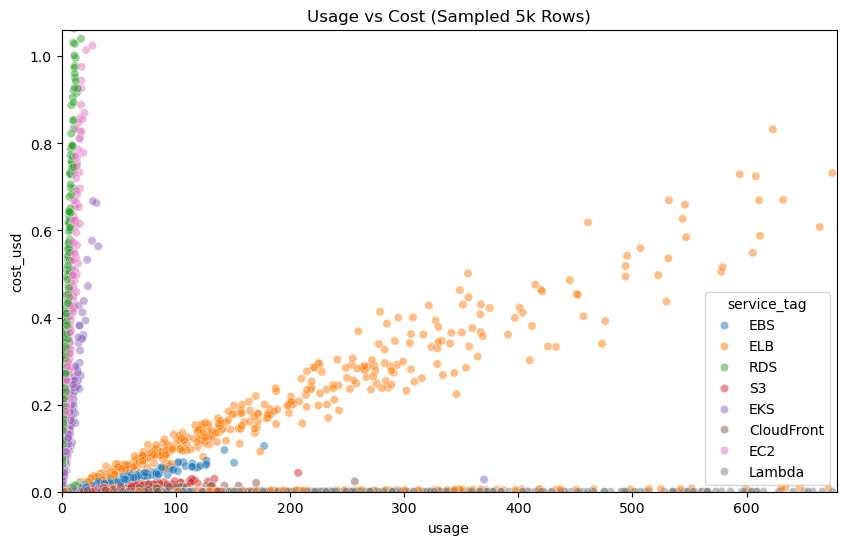

In [17]:
# Usage vs Cost relationship

plot.figure(figsize=(10,6))
sns.scatterplot(data=df.sample(5000), x='usage', y='cost_usd', hue='service_tag', alpha=0.5)
plot.xlim(0, df['usage'].quantile(0.99))
plot.ylim(0, df['cost_usd'].quantile(0.99))
plot.title('Usage vs Cost (Sampled 5k Rows)')
plot.show()

#### Insights:
* ELB shows an upward trend. As usage increases, cost increases proportionally. This means ELB costs scale directly with usage.
* RDB and EC2 services show high cost even at low usage.
* EKS similar to RDB and EC2, shows some higher costs at low usage.
* EBS has a moderate upward trend, though less steep compared to ELB. This suggests that EBS costs increases with usage but not as aggressively.
* S3, CloudFront and Lambda show low cost even at high usage. This means they are cost efficient services relative to how much they are used. They deliver high value at low costs, even under heavy workloads.
* RDB, EC2 and EKS are expensive even at low usage, so teams should focus on rightsizing and optimizing configurations. For executives, this means these services are major cost drivers regardless of the scale.
* ELB costs scale linearly with demand, so sudden traffic surges will directly increase costs.
* EBS grows more gradually but still needs monitoring for long term storage expansion.
* Some services (like RDS, EC2, EKS) are expensive no matter how little you use them. Others (like ELB, EBS) get more costly only when usage spikes. A few services (S3, CloudFront, Lambda) are very cost-efficient, even at high usage.

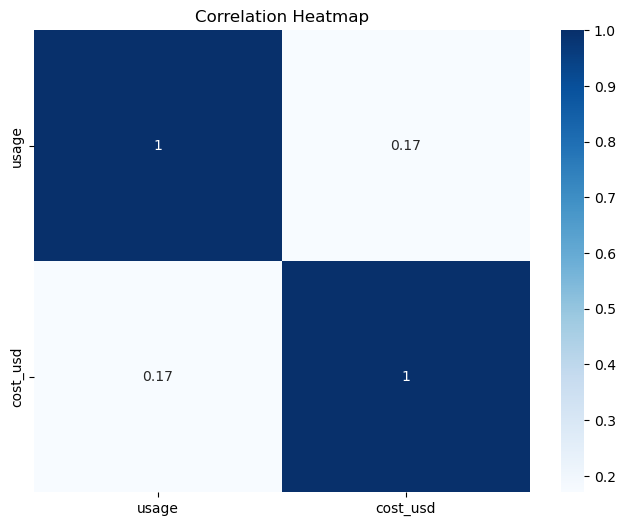

In [18]:
# Correlation heatmap

plot.figure(figsize=(8,6))
sns.heatmap(df[['usage', 'cost_usd']].corr(), annot=True, cmap='Blues')
plot.title('Correlation Heatmap')
plot.show()

#### Insights:
* The correlation between usage and cost (USD) is only 0.17, which indicates a weak positive relationship.
* This indicates that costs are not driven by usage alone.
* Pricing is influenced by service type, instance size, base charges, spikes and currency inconsistencies.
* This also indicates that outliers like injected spikes, imputed costs, and anomalies weaken the overall linear relationship.
* For anomaly detection, this is good because it means usage alone cannot explain cost spikes, maling anomaly detection valuable.
* For stakeholders, lower correlation means managing costs is not as simple as reducing usage.
* Finance and engineering teams need multi-factor analysis like service type, scaling patterns, pricing model to understand and contro cloud spend.
* The weak correlation shows that cloud costs are influenced by more than just usage. Even small workloads can be expensive if the service has high base costs (like RDS), and anomalies can cause spikes independent of normal usage.

### Conclusion

* **Overall Trends**
    * Daily cloud costs show fluctuations across the year, with major spikes in January, May, and September 2025.
    * These spikes are linked to RDS in Jan/May and ELB in Sept.
* **Service-wise Insights**
    * RDS is the biggest cost driver, responsible for more than 40% of anomalies.
    * EC2, ELB, and EKS also show frequent anomalies, making them critical services to monitor.
    * S3, Lambda, CloudFront, and EBS contribute little to anomalies and remain relatively stable.
* **Usage vs cost analysis shows:**
    * RDS, EC2, EKS → high costs even at low usage.
    * ELB, EBS → scale proportionally with usage.
    * S3, Lambda, CloudFront → very cost-efficient even at high usage.
* **Team-wise Insights**
    * Anomalies are spread fairly evenly across teams (~16% each).
    * The Payments team shows slightly more anomalies (likely due to RDS-heavy workloads).
    * The Development Tools team has fewer anomalies, meaning their workloads are stable.
* **Imputation Analysis**
    * Missing cost values were imputed, but the imputed rows are skewed towards low-cost values.
    * This introduces some bias (slight underestimation of total cost), but the overall anomaly patterns remain valid.
* **Correlation**
    * The correlation between usage and cost is only 0.17, showing a weak relationship.
    * This means costs are influenced not just by usage but also by service type, instance size, and anomalies.
* Cloud cost spikes are not random, they are linked to specific services (mainly RDS and ELB) and business-critical teams (like Payments).
* Cost management must go beyond tracking usage; it requires service-level monitoring, anomaly detection, and optimization strategies.
* The dataset is now well-understood and ready for Phase 3 (CONSTRUCT → modeling for anomaly detection and forecasting).